## Custom Deep Neural Network

In [2]:
import argparse
import os, sys
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
%matplotlib inline

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset as Dataset

# You cannot change this line.
from tools.dataloader import CIFAR10

In [3]:
#Load dataset
PATH = './data/'

train_x, train_y = np.load(os.path.join(PATH, "cifar10_train_val/cifar10-batches-images-train.npy")), np.load(os.path.join(PATH, "cifar10_train_val/cifar10-batches-labels-train.npy"))
val_x, val_y = np.load(os.path.join(PATH, "cifar10_train_val/cifar10-batches-images-val.npy")), np.load(os.path.join(PATH, "cifar10_train_val/cifar10-batches-labels-val.npy"))
test_x = np.load(os.path.join(PATH, "cifar10-batches-images-test.npy"))

#transforms
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])])
transform_test = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])])

In [10]:
#Hyper-parameter
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-2
EPOCHS = 35
CHECKPOINT_PATH = "./saved_model"

In [11]:
#Load datasets
class data(Dataset):
    def __init__(self, imgs, labels, transform):
        self.X = imgs
        self.y = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = self.X[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y[index]

train_data = data(train_x, train_y, transform = transform_train)
val_data = data(val_x, val_y, transform = transform_val)

# create empty label for test_data
empty = [-1] * test_x.shape[0]
test_data = data(test_x, empty, transform = transform_test)


train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = TRAIN_BATCH_SIZE, num_workers = 1)
val_loader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = TRAIN_BATCH_SIZE, num_workers = 1)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = False, batch_size = TRAIN_BATCH_SIZE, num_workers = 1)

In [12]:
#Wnet model
class W_net(nn.Module):
    def __init__(self):
        super(W_net, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm1 = nn.BatchNorm2d(6)
        #self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm2 = nn.BatchNorm2d(16)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm3 = nn.BatchNorm2d(32)
        #self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm4 = nn.BatchNorm2d(64)
        #self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm5 = nn.BatchNorm2d(128)
        self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm6 = nn.BatchNorm2d(256)
        #self.max_pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm7 = nn.BatchNorm2d(512)
        #self.max_pool7 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv8 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True)
        self.BatchNorm8 = nn.BatchNorm2d(1024)
        self.max_pool8 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(16384, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = self.BatchNorm1(x)
        #x = self.max_pool1(x)
        
        x = F.relu(self.Conv2(x))
        x = self.BatchNorm2(x)
        x = self.max_pool2(x)
        
        x = F.relu(self.Conv3(x))
        x = self.BatchNorm3(x)
        #x = self.max_pool3(x)
        
        x = F.relu(self.Conv4(x))
        x = self.BatchNorm4(x)
        #x = self.max_pool4(x)
        
        x = F.relu(self.Conv5(x))
        x = self.BatchNorm5(x)
        x = self.max_pool5(x)
        
        x = F.relu(self.Conv6(x))
        x = self.BatchNorm6(x)
        #x = self.max_pool6(x)
        
        x = F.relu(self.Conv7(x))
        x = self.BatchNorm7(x)
        #x = self.max_pool7(x)
        
        x = F.relu(self.Conv8(x))
        x = self.BatchNorm8(x)
        x = self.max_pool8(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [13]:
#send wnet to gpu
wnet = W_net()
wnet = wnet.to(device)

In [14]:
#Define loss function
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(wnet.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=REG)

In [15]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/wnet_model_final.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    wnet.load_state_dict(ckpt['wnet'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

global_step = 0
best_val_acc = 0

train_loss_5 = []
val_loss_5 = []
train_acc_5 = []
val_acc_5 = []

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    wnet.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    #print(len(train_loader))
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = wnet(inputs)
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Calculate accuracy
        total_examples += targets.size(0)
        correct_examples += torch.sum(predicted == targets.data).float()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    
    train_loss_5.append(avg_loss)
    train_acc_5.append(avg_acc)
    
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    wnet.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = wnet(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Calculate accuracy
            total_examples += targets.size(0)
            correct_examples += torch.sum(predicted == targets.data).float()
            val_loss += loss

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    val_loss_5.append(avg_loss)
    val_acc_5.append(avg_acc)
    
    DECAY_EPOCHS = 2
    DECAY = 0.8
    if i % DECAY_EPOCHS == 0 and i != 0:
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            current_learning_rate = current_learning_rate*DECAY
            param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'wnet': wnet.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'wnet_model_final.h5'))

print("Optimization finished.")

[Errno 2] No such file or directory: './saved_model/wnet_model_final.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-09-29 13:42:17.278481
Epoch 0:
Training loss: 1.5570, Training accuracy: 0.4499
2019-09-29 13:42:45.144958
Validation...
Validation loss: 1.1308, Validation accuracy: 0.5798
Saving ...
2019-09-29 13:42:46.389666
Epoch 1:
Training loss: 1.0973, Training accuracy: 0.6130
2019-09-29 13:43:09.982170
Validation...
Validation loss: 0.8808, Validation accuracy: 0.6872
Saving ...
2019-09-29 13:43:11.474962
Epoch 2:
Training loss: 0.9390, Training accuracy: 0.6748
2019-09-29 13:43:34.863351
Validation...
Validation loss: 0.7964, Validation accuracy: 0.7176
Current learning rate has decayed to 0.008000
Saving ...
2019-09-29 13:43:36.044988
Epoch 3:
Training loss: 0.8078, Training accuracy: 0.7204
2019-09-29 13:43:59.569383
Validation...
Validation loss: 0.6797, Validation accuracy: 0.7608
Saving ...
2019-09-29 13:44:00.746843
Epoch 4:

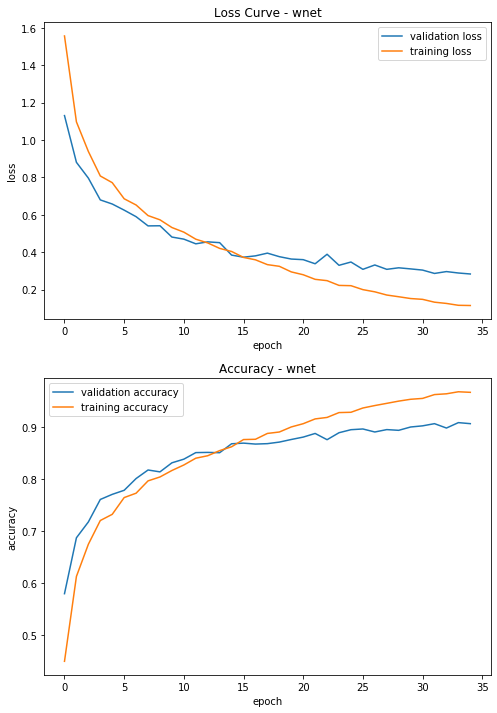

In [17]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.title('Loss Curve - wnet')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(val_loss_5, label='validation loss')
plt.plot(train_loss_5, label='training loss')
plt.legend()

plt.subplot(212)
plt.title('Accuracy - wnet')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(val_acc_5, label='validation accuracy')
plt.plot(train_acc_5, label='training accuracy')
plt.legend()

In [16]:
## load model
CKPT_PATH = "./saved_model/wnet_model2.h5"
ckpt = get_checkpoint(CKPT_PATH)
wnet.load_state_dict(ckpt['wnet'])
start_epoch = ckpt['epoch'] + 1
current_learning_rate = ckpt['lr']

## predicted values
pred = np.zeros([10000,2])
pred[:,0] = np.arange(10000)

wnet.eval()
with torch.no_grad():
    for idx, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = wnet(inputs)
        _, predicted = outputs.max(1)
        pred[idx*TRAIN_BATCH_SIZE:(idx*TRAIN_BATCH_SIZE+len(predicted)), 1] =predicted.cpu().data.numpy()
        
np.savetxt('pred_labels2.csv', pred.astype(int), fmt = "%d", delimiter=',', header='Id,Category', comments='')